# This is Yolov5 with Intel Openvino env


you need to prepare the env, openvino_2021.4.752 is been used, Python3.8 is been used.

Anaconda standalone env is appreciated to verify

# Verify Python Version

In [44]:
import sys
print(sys.version)
import os
root = os.getcwd()
print(root)

3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
C:\Users\qianmichael\Desktop\yolov5\yolov5-openvino


# Import tutorial module and Openvino module

In [2]:
import logging
import sys
from argparse import ArgumentParser, SUPPRESS
from math import exp as exp
from time import time
import numpy as np
import cv2
from openvino.inference_engine import IENetwork, IECore

In [3]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']  # class names

In [4]:
logging.basicConfig(format="[ %(levelname)s ] %(message)s", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger()

Input source and IR file for openvino inference

Input source, parameter and IR file for openvino inference

In [5]:
model_input = 'yolov5s.xml'

In [6]:
source_input = 'bus01.jpg'

In [7]:
prob_threshold = 0.5

In [8]:
iou_threshold = 0.4

In [46]:
save_path = './runs/'

In [10]:
print (model_input)

yolov5s.xml


Yolo parameters extracting

In [11]:
class YoloParams:
    # ------------------------------------------- Extracting layer parameters ------------------------------------------
    # Magic numbers are copied from yolo samples
    def __init__(self,  side):
        self.num = 3 #if 'num' not in param else int(param['num'])
        self.coords = 4 #if 'coords' not in param else int(param['coords'])
        self.classes = 80 #if 'classes' not in param else int(param['classes'])
        self.side = side
        self.anchors = [10.0, 13.0, 16.0, 30.0, 33.0, 23.0, 30.0, 61.0, 62.0, 45.0, 59.0, 119.0, 116.0, 90.0, 156.0,
                        198.0,
                        373.0, 326.0] #if 'anchors' not in param else [float(a) for a in param['anchors'].split(',')]

        #self.isYoloV3 = False

        #if param.get('mask'):
        #    mask = [int(idx) for idx in param['mask'].split(',')]
        #    self.num = len(mask)

        #    maskedAnchors = []
        #    for idx in mask:
        #        maskedAnchors += [self.anchors[idx * 2], self.anchors[idx * 2 + 1]]
        #    self.anchors = maskedAnchors

        #    self.isYoloV3 = True # Weak way to determine but the only one.

    def log_params(self):
        params_to_print = {'classes': self.classes, 'num': self.num, 'coords': self.coords, 'anchors': self.anchors}
        [log.info("         {:8}: {}".format(param_name, param)) for param_name, param in params_to_print.items()]


letter box is used for padding input img or frame into 640 x 640 format

letter box is used for padding input img or frame into 640 x 640 format, 114 means padding with gray color

In [12]:
def letterbox(img, size=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    w, h = size

    # Scale ratio (new / old)
    r = min(h / shape[0], w / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = w - new_unpad[0], h - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (w, h)
        ratio = w / shape[1], h / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border

    top2, bottom2, left2, right2 = 0, 0, 0, 0
    if img.shape[0] != h:
        top2 = (h - img.shape[0])//2
        bottom2 = top2
        img = cv2.copyMakeBorder(img, top2, bottom2, left2, right2, cv2.BORDER_CONSTANT, value=color)  # add border
    elif img.shape[1] != w:
        left2 = (w - img.shape[1])//2
        right2 = left2
        img = cv2.copyMakeBorder(img, top2, bottom2, left2, right2, cv2.BORDER_CONSTANT, value=color)  # add border
    return img


In [13]:
def scale_bbox(x, y, height, width, class_id, confidence, im_h, im_w, resized_im_h=640, resized_im_w=640):
    gain = min(resized_im_w / im_w, resized_im_h / im_h)  # gain  = old / new
    pad = (resized_im_w - im_w * gain) / 2, (resized_im_h - im_h * gain) / 2  # wh padding
    x = int((x - pad[0])/gain)
    y = int((y - pad[1])/gain)

    w = int(width/gain)
    h = int(height/gain)
 
    xmin = max(0, int(x - w / 2))
    ymin = max(0, int(y - h / 2))
    xmax = min(im_w, int(xmin + w))
    ymax = min(im_h, int(ymin + h))
    # Method item() used here to convert NumPy types to native types for compatibility with functions, which don't
    # support Numpy types (e.g., cv2.rectangle doesn't support int64 in color parameter)
    return dict(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, class_id=class_id.item(), confidence=confidence.item())


In [14]:
def entry_index(side, coord, classes, location, entry):
    side_power_2 = side ** 2
    n = location // side_power_2
    loc = location % side_power_2
    return int(side_power_2 * (n * (coord + classes + 1) + entry) + loc)


Object inference

In [15]:
def parse_yolo_region(blob, resized_image_shape, original_im_shape, params, threshold):
    
    # ------------------------------------------ Validating output parameters ------------------------------------------    
    out_blob_n, out_blob_c, out_blob_h, out_blob_w = blob.shape
    # predictions = sigmoid(blob)
    predictions = 1.0/(1.0+np.exp(-blob)) 
                   
    assert out_blob_w == out_blob_h, "Invalid size of output blob. It sould be in NCHW layout and height should " \
                                     "be equal to width. Current height = {}, current width = {}" \
                                     "".format(out_blob_h, out_blob_w)

    # ------------------------------------------ Extracting layer parameters -------------------------------------------
    orig_im_h, orig_im_w = original_im_shape
    resized_image_h, resized_image_w = resized_image_shape
    objects = list()
 
    side_square = params.side * params.side

    # ------------------------------------------- Parsing YOLO Region output -------------------------------------------
    bbox_size = int(out_blob_c/params.num) #4+1+num_classes [x,y,h,w, confidence, num_class]

    for row, col, n in np.ndindex(params.side, params.side, params.num):
        bbox = predictions[0, n*bbox_size:(n+1)*bbox_size, row, col]
        
        x, y, width, height, object_probability = bbox[:5]
        class_probabilities = bbox[5:]
        if object_probability < threshold:
            continue
        x = (2*x - 0.5 + col)*(resized_image_w/out_blob_w)
        y = (2*y - 0.5 + row)*(resized_image_h/out_blob_h)
        if int(resized_image_w/out_blob_w) == 8 & int(resized_image_h/out_blob_h) == 8: #80x80, 
            idx = 0
        elif int(resized_image_w/out_blob_w) == 16 & int(resized_image_h/out_blob_h) == 16: #40x40
            idx = 1
        elif int(resized_image_w/out_blob_w) == 32 & int(resized_image_h/out_blob_h) == 32: # 20x20
            idx = 2

        width = (2*width)**2* params.anchors[idx * 6 + 2 * n]
        height = (2*height)**2 * params.anchors[idx * 6 + 2 * n + 1]
        class_id = np.argmax(class_probabilities)
        confidence = object_probability
        objects.append(scale_bbox(x=x, y=y, height=height, width=width, class_id=class_id, confidence=confidence,
                                  im_h=orig_im_h, im_w=orig_im_w, resized_im_h=resized_image_h, resized_im_w=resized_image_w))
    return objects

Calculate IoU

In [16]:
def intersection_over_union(box_1, box_2):
    width_of_overlap_area = min(box_1['xmax'], box_2['xmax']) - max(box_1['xmin'], box_2['xmin'])
    height_of_overlap_area = min(box_1['ymax'], box_2['ymax']) - max(box_1['ymin'], box_2['ymin'])
    if width_of_overlap_area < 0 or height_of_overlap_area < 0:
        area_of_overlap = 0
    else:
        area_of_overlap = width_of_overlap_area * height_of_overlap_area
    box_1_area = (box_1['ymax'] - box_1['ymin']) * (box_1['xmax'] - box_1['xmin'])
    box_2_area = (box_2['ymax'] - box_2['ymin']) * (box_2['xmax'] - box_2['xmin'])
    area_of_union = box_1_area + box_2_area - area_of_overlap
    if area_of_union == 0:
        return 0
    return area_of_overlap / area_of_union

# Input and Inference

## 1. Plugin initialization for specified device and load extensions library if specified

In [78]:
    log.info("Creating Inference Engine...")
    ie = IECore()

[ INFO ] Creating Inference Engine...


## 2. Reading the IR generated by the Model Optimizer (.xml and .bin files)

In [79]:
    model = model_input
    log.info(f"Loading network:\n\t{model}")
    net = ie.read_network(model=model)

[ INFO ] Loading network:
	yolov5s.xml


## 3.Preparing inputs 

In [80]:
    log.info("Preparing inputs")
    input_blob = next(iter(net.input_info))
    #  Defaulf batch_size is 1
    net.batch_size = 1
    print (input_blob)
    

[ INFO ] Preparing inputs
images


In [81]:
    # Read and pre-process input images
    n, c, h, w = net.input_info[input_blob].input_data.shape
    print (n,c,h,w)

1 3 640 640


In [82]:
    labels_map = None

    input_stream = 0 if source_input == "cam" else source_input
    # log.info("Preparing inputs", args.input)
    is_async_mode = True
    cap = cv2.VideoCapture(input_stream)
    number_input_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print ("input number input frames:", number_input_frames)
    number_input_frames = 1 if number_input_frames != -1 and number_input_frames < 0 else number_input_frames

input number input frames: 1


In [83]:
    wait_key_code = 1

    # Number of frames in picture is 1 and this will be read in cycle. Sync mode is default value for this case
    if number_input_frames != 1:
        ret, frame = cap.read()
    else:
        is_async_mode = False
        wait_key_code = 0

## 4. Loading model to the plugin

In [84]:
    log.info("Loading model to the plugin")
    exec_net = ie.load_network(network=net, num_requests=2, device_name='CPU')

    cur_request_id = 0
    next_request_id = 1
    render_time = 0
    parsing_time = 0

[ INFO ] Loading model to the plugin


## 5. Doing inference

In [85]:
    log.info("Starting inference...")
    print("To close the application, press 'CTRL+C' here or switch to the output window and press ESC key")
    print("To switch between sync/async modes, press TAB key in the output window")

[ INFO ] Starting inference...
To close the application, press 'CTRL+C' here or switch to the output window and press ESC key
To switch between sync/async modes, press TAB key in the output window


Here is the first asynchronous point: in the Async mode, we capture frame to populate the NEXT infer request in the regular mode, we capture frame to the CURRENT infer request

In [86]:
    print("Input ret and shape:", ret, frame.shape)
    if is_async_mode:
        ret, next_frame = cap.read()
    else:
        ret, frame = cap.read()

Input ret and shape: True (1080, 810, 3)


./runs/source.jpg


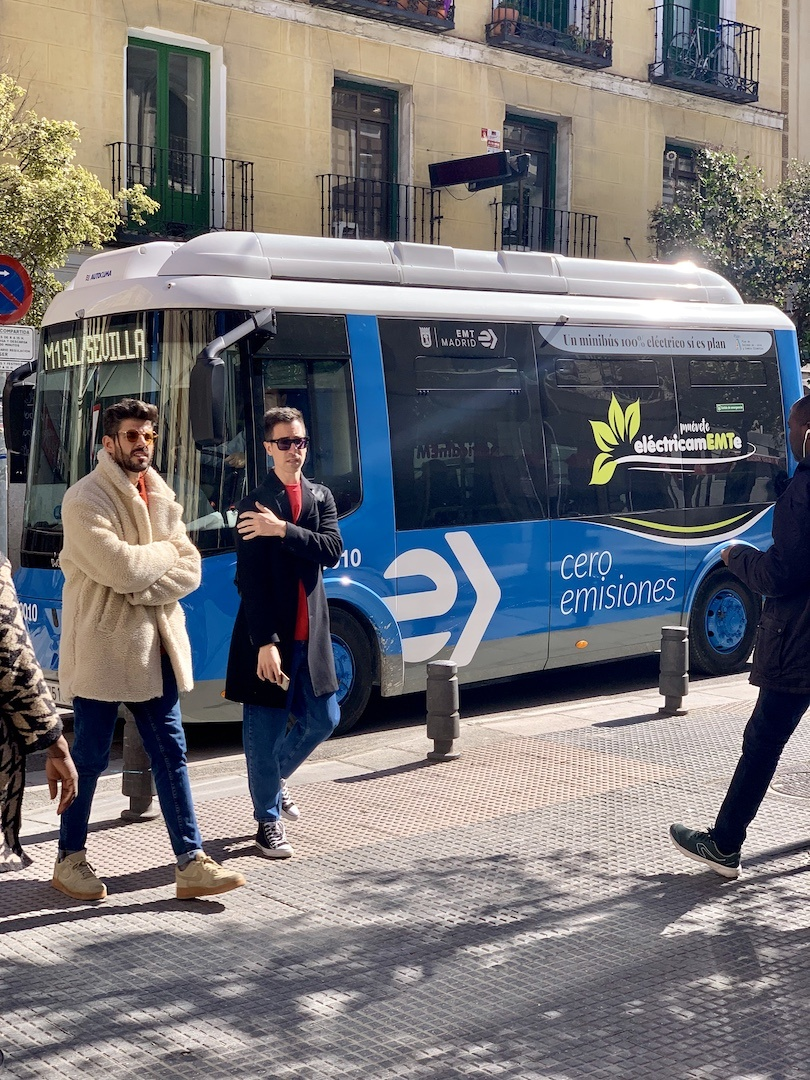

In [87]:
    cv2.imwrite(save_path + "source.jpg", frame)
    print (save_path + "source.jpg")
    from IPython.display import display, Image
    display( Image( filename = save_path + 'source.jpg' ))

In [88]:
    if is_async_mode:
        request_id = next_request_id
        in_frame = letterbox(frame, (w, h))

    else:
        request_id = cur_request_id
        in_frame = letterbox(frame, (w, h))     
    
    in_frame0 = in_frame

./runs/padding picture.jpg


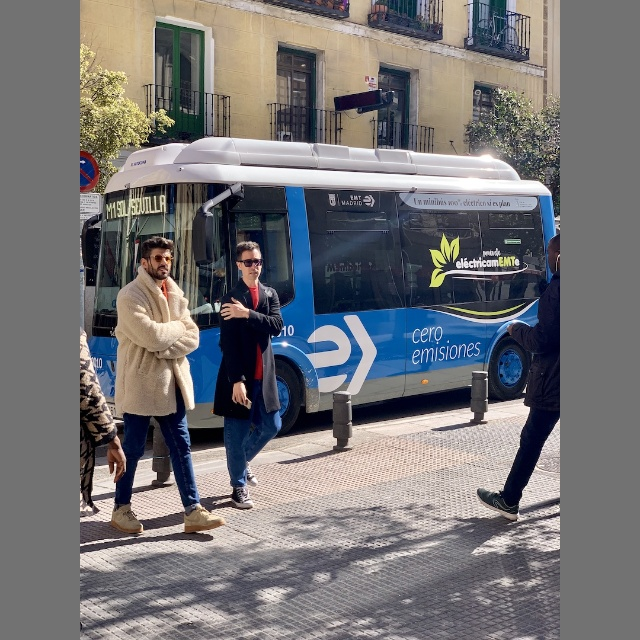

In [89]:
    cv2.imwrite(save_path + "padding picture.jpg", in_frame0)
    print (save_path + "padding picture.jpg")
    from IPython.display import display, Image
    display( Image( filename = save_path + 'padding picture.jpg' ))

In [90]:
    print("Input shape with padding:", in_frame0.shape)
    # resize input_frame to network size
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    print("Transpose output:",in_frame.shape)
    in_frame = in_frame.reshape((n, c, h, w))
    print("Reshape output:",in_frame.shape)

Input shape with padding: (640, 640, 3)
Transpose output: (3, 640, 640)
Reshape output: (1, 3, 640, 640)


Start inference

In [91]:
    start_time = time()
    exec_net.start_async(request_id=request_id, inputs={input_blob: in_frame})
    det_time = time() - start_time

Collecting object detection results

In [92]:
    objects = list()

OpenVino Inference

> start_async(self, request_id, inputs=None)

Starts asynchronous inference for specified infer request. Wraps InferRequest.async_infer() method of the InferRequest class.

> Parameters

> request_id – Index of infer request to start inference

> inputs – A dictionary that maps input layer names to numpy.ndarray objects of proper shape with input data for the layer.

> Returns: A handler of specified infer request, which is an instance of the InferRequest class.

Usage example:

> infer_request_handle = exec_net.start_async(request_id=0, inputs={input_blob: image}) 
> 
> infer_status = infer_request_handle.wait() 
> 
> res = infer_request_handle.output_blobs[out_blob_name]

In [93]:
    if exec_net.requests[cur_request_id].wait(-1) == 0:
        output = exec_net.requests[cur_request_id].output_blobs
        print(list(output))
        start_time = time()
        for layer_name, out_blob in output.items():
            print ("Out blob buffer shapr should be :", out_blob.buffer.shape)
            print ("in_frame.shape[2:] should be :", in_frame.shape[:])
            print ("frame.shape[:-1] should be :", frame.shape[:])
            #out_blob.buffer.shape[2] is 80 or 40 or 20
            layer_params = YoloParams(side=out_blob.buffer.shape[2])
            
            log.info("Layer {} parameters: ".format(layer_name))
            layer_params.log_params()
            objects += parse_yolo_region(out_blob.buffer, in_frame.shape[2:],
                                        #in_frame.shape[2:], layer_params,
                                        frame.shape[:-1], layer_params,
                                        prob_threshold)
        parsing_time = time() - start_time

['Conv_198', 'Conv_233', 'Conv_268']
Out blob buffer shapr should be : (1, 255, 80, 80)
in_frame.shape[2:] should be : (1, 3, 640, 640)
frame.shape[:-1] should be : (1080, 810, 3)
[ INFO ] Layer Conv_198 parameters: 
[ INFO ]          classes : 80
[ INFO ]          num     : 3
[ INFO ]          coords  : 4
[ INFO ]          anchors : [10.0, 13.0, 16.0, 30.0, 33.0, 23.0, 30.0, 61.0, 62.0, 45.0, 59.0, 119.0, 116.0, 90.0, 156.0, 198.0, 373.0, 326.0]
Out blob buffer shapr should be : (1, 255, 40, 40)
in_frame.shape[2:] should be : (1, 3, 640, 640)
frame.shape[:-1] should be : (1080, 810, 3)
[ INFO ] Layer Conv_233 parameters: 
[ INFO ]          classes : 80
[ INFO ]          num     : 3
[ INFO ]          coords  : 4
[ INFO ]          anchors : [10.0, 13.0, 16.0, 30.0, 33.0, 23.0, 30.0, 61.0, 62.0, 45.0, 59.0, 119.0, 116.0, 90.0, 156.0, 198.0, 373.0, 326.0]
Out blob buffer shapr should be : (1, 255, 20, 20)
in_frame.shape[2:] should be : (1, 3, 640, 640)
frame.shape[:-1] should be : (1080, 

Filtering overlapping boxes with respect to the --iou_threshold CLI parameter

In [94]:
    objects = sorted(objects, key=lambda obj : obj['confidence'], reverse=True)
    for i in range(len(objects)):
        print(objects[i]['confidence'])
        if objects[i]['confidence'] == 0:
            continue
        for j in range(i + 1, len(objects)):
            if intersection_over_union(objects[i], objects[j]) > iou_threshold:
                objects[j]['confidence'] = 0

0.8613094687461853
0
0.8367061018943787
0
0
0
0
0
0.7885450720787048
0.7864921689033508
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Drawing objects with respect to the --prob_threshold CLI parameter

In [95]:
    objects = [obj for obj in objects if obj['confidence'] >= prob_threshold]

    if len(objects):
        log.info("\nDetected boxes for batch {}:".format(1))
        log.info(" Class ID | Confidence | XMIN | YMIN | XMAX | YMAX | COLOR ")

    origin_im_size = frame.shape[:-1]
    print(origin_im_size)
    for obj in objects:
        # Validation bbox of detected object
        if obj['xmax'] > origin_im_size[1] or obj['ymax'] > origin_im_size[0] or obj['xmin'] < 0 or obj['ymin'] < 0:
            continue
        color = (int(min(obj['class_id'] * 12.5, 255)),
                    min(obj['class_id'] * 7, 255), min(obj['class_id'] * 5, 255))
        det_label = labels_map[obj['class_id']] if labels_map and len(labels_map) >= obj['class_id'] else \
            str(obj['class_id'])

        log.info(
            "{:^9} | {:10f} | {:4} | {:4} | {:4} | {:4} | {} ".format(names[int(det_label)], obj['confidence'], obj['xmin'],
                                                                            obj['ymin'], obj['xmax'], obj['ymax'],
                                                                            color))

        cv2.rectangle(frame, (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']), color, 2)
        cv2.putText(frame,
                        names[int(det_label)] + ' ' + str(round(obj['confidence'] * 100, 1)) + ' %',
                        (obj['xmin'], obj['ymin'] - 7), cv2.FONT_HERSHEY_COMPLEX, 0.6, color, 1)  

[ INFO ] 
Detected boxes for batch 1:
[ INFO ]  Class ID | Confidence | XMIN | YMIN | XMAX | YMAX | COLOR 
(1080, 810)
[ INFO ]  person   |   0.861309 |  220 |  407 |  345 |  875 | (0, 0, 0) 
[ INFO ]  person   |   0.836706 |  662 |  386 |  810 |  880 | (0, 0, 0) 
[ INFO ]    bus    |   0.788545 |   14 |  222 |  797 |  784 | (62, 35, 25) 
[ INFO ]  person   |   0.786492 |   57 |  397 |  214 |  917 | (0, 0, 0) 


Draw performance stats over frame

./runs/DetectionResults.jpg


<>:1: DeprecationWarning: invalid escape sequence \A
<>:1: DeprecationWarning: invalid escape sequence \A
C:\Users\qianmichael\AppData\Local\Temp\ipykernel_22312\4128514837.py:1: DeprecationWarning: invalid escape sequence \A
  inf_time_message = "Inference time: N\A for async mode" if is_async_mode else \


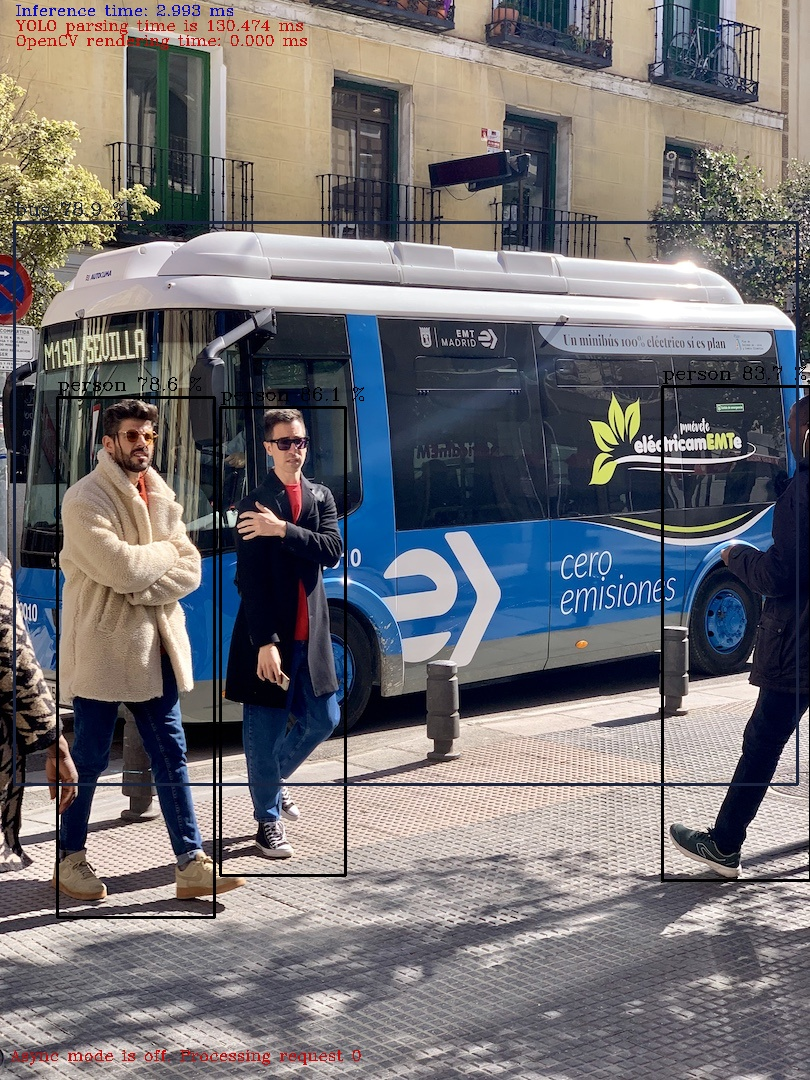

In [96]:
    inf_time_message = "Inference time: N\A for async mode" if is_async_mode else \
        "Inference time: {:.3f} ms".format(det_time * 1e3)
    render_time_message = "OpenCV rendering time: {:.3f} ms".format(render_time * 1e3)
    async_mode_message = "Async mode is on. Processing request {}".format(cur_request_id) if is_async_mode else \
            "Async mode is off. Processing request {}".format(cur_request_id)
    parsing_message = "YOLO parsing time is {:.3f} ms".format(parsing_time * 1e3)

    cv2.putText(frame, inf_time_message, (15, 15), cv2.FONT_HERSHEY_COMPLEX, 0.5, (200, 10, 10), 1)
    cv2.putText(frame, render_time_message, (15, 45), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
    cv2.putText(frame, async_mode_message, (10, int(origin_im_size[0] - 20)), cv2.FONT_HERSHEY_COMPLEX, 0.5,
                    (10, 10, 200), 1)
    cv2.putText(frame, parsing_message, (15, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)

    cv2.imwrite(save_path + "DetectionResults.jpg", frame)
    print (save_path + "DetectionResults.jpg")
    from IPython.display import display, Image
    display( Image( filename = save_path + 'DetectionResults.jpg' ))